In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Projects/Churn Prediction/'
train_df = pd.read_csv(file_path + 'train.csv')
test_df = pd.read_csv(file_path + 'test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#EDA and Data Preprocessing

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               110023 non-null  int64  
 1   CustomerId       110023 non-null  int64  
 2   Surname          110023 non-null  object 
 3   CreditScore      110023 non-null  int64  
 4   Geography        110023 non-null  object 
 5   Gender           110023 non-null  object 
 6   Age              110023 non-null  float64
 7   Tenure           110023 non-null  int64  
 8   Balance          110023 non-null  float64
 9   NumOfProducts    110023 non-null  int64  
 10  HasCrCard        110023 non-null  float64
 11  IsActiveMember   110023 non-null  float64
 12  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 10.9+ MB


None of the column vales are missing

The target variable is Exited column. Since it is missing from test_df. We will use train_df as the total dataset and we will perform train test split on train_df afterwards.

In [ ]:
data = train_df
## Some descriptive statistics of data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,165034.0,8.251650e+04,47641.356500,0.00,41258.25,82516.5,1.237748e+05,165033.00
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,15633141.00,15690169.0,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,597.00,659.0,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,32.00,37.0,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.00,5.0,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.00,0.0,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.00,2.0,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.00,1.0,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.00,0.0,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,74637.57,117948.0,1.551525e+05,199992.48


In [ ]:
# check for missing values
data.isnull().sum()

,0
id,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [ ]:
print(data.dtypes)

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object


From the descriptive statistics it seems like Tenure is categorical.
We identify the categorical and numerical columns based on a threshold of each columns unique value counts

In [ ]:
# Unique value counts for each column except the target column
unique_counts = data.iloc[:,:-1].nunique()

# Threshold
threshold = 5

continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

print(f"Categorical Variables: {categorical_vars}")
print(f"Continuous Variables: {continuous_vars}")

Categorical Variables: ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
Continuous Variables: ['id', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


In [ ]:
print(data['Surname'].describe())
print(data['CustomerId'].describe())

count     165034
unique      2797
top         Hsia
freq        2456
Name: Surname, dtype: object
count    1.650340e+05
mean     1.569201e+07
std      7.139782e+04
min      1.556570e+07
25%      1.563314e+07
50%      1.569017e+07
75%      1.575682e+07
max      1.581569e+07
Name: CustomerId, dtype: float64


We can observe that CustomerId is unique for each customer. We won't be using this as a feature for our task. Also we won't use Surname, id as features

In [ ]:
continuous_vars.remove('id')
continuous_vars.remove('CustomerId')
continuous_vars.remove('Surname')
# categorical_vars.remove('Gender')

We perform categorical variables analysis

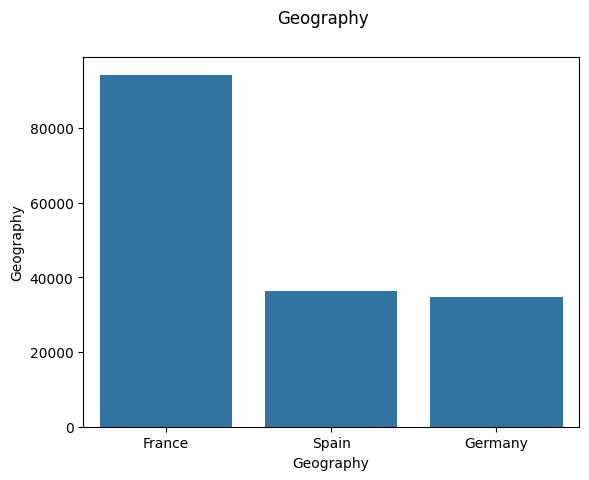

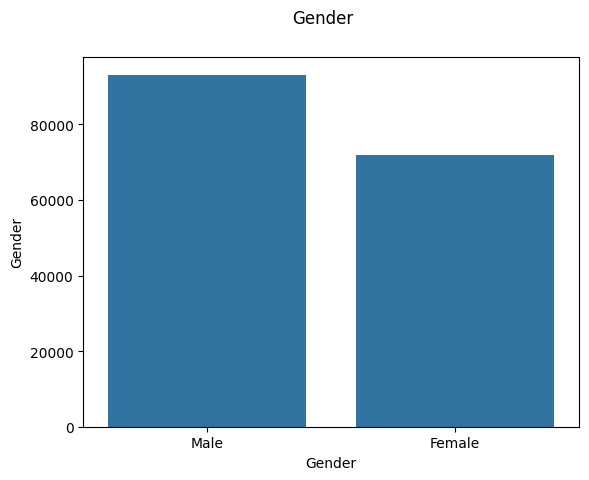

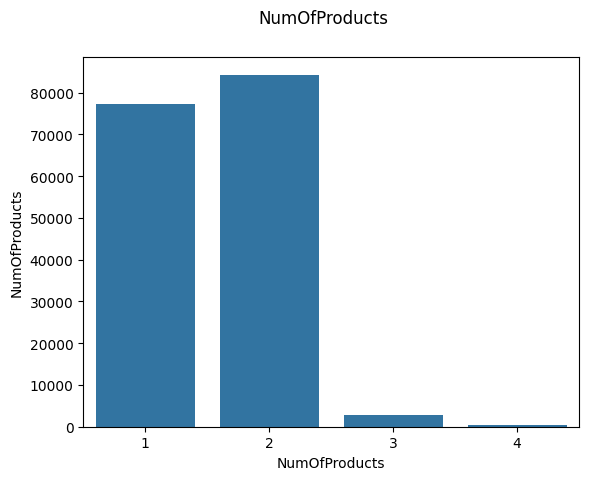

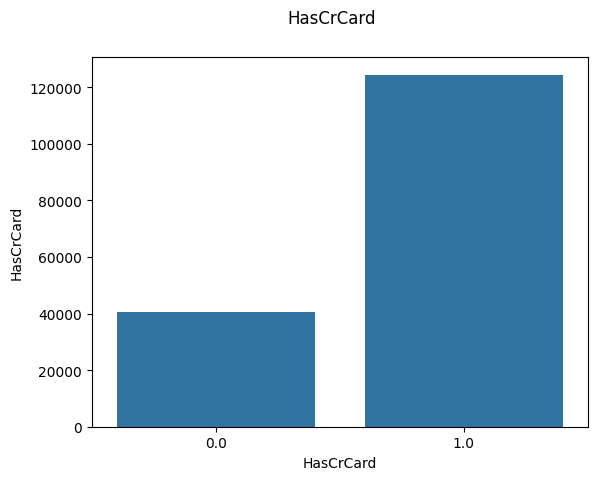

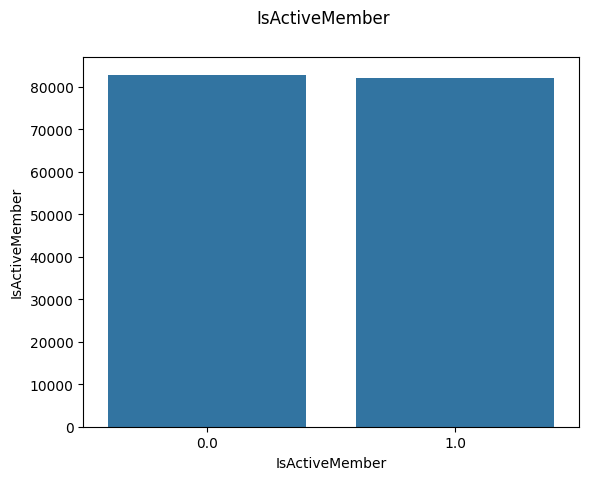

In [ ]:
for column in categorical_vars:
    f,ax=plt.subplots()
    ax.set_ylabel(f'{column}')
    sns.countplot(x=column,data=data)
    plt.suptitle(f'{column}')
    plt.show()

We notice the following observations:
1. The majority of customers are from France.
2. There is a higher proportion of male customers.
3. Most customers have a tenure ranging from 1 to 9 years.
4. The majority of customers use 1 to 2 bank products.
5. Most customers have a credit card.
6. The number of active and inactive members is nearly balanced.

We won't consider the Geography as feature for our task beacause of potential of bias introduction in the models during training.

We now perform continuous variables analysis


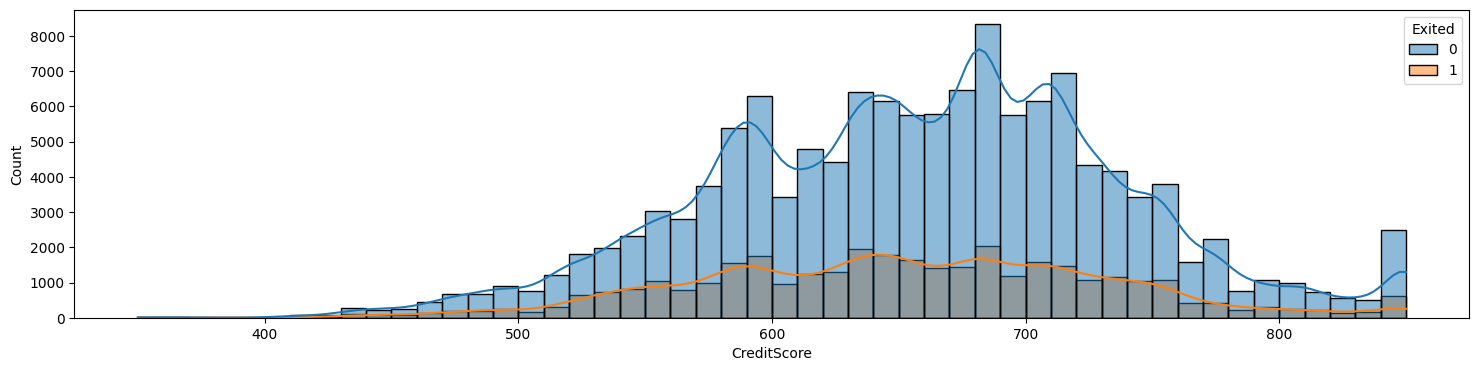

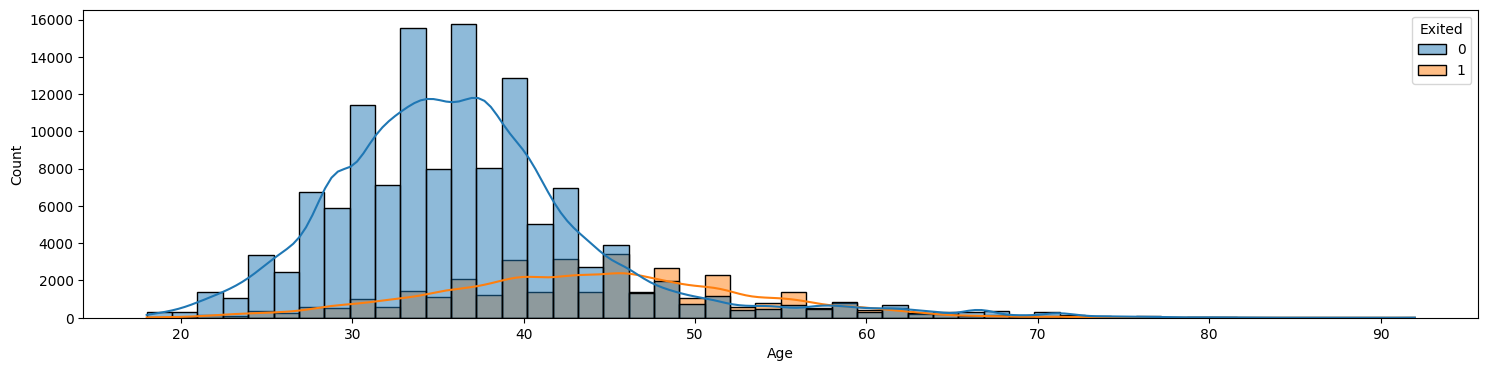

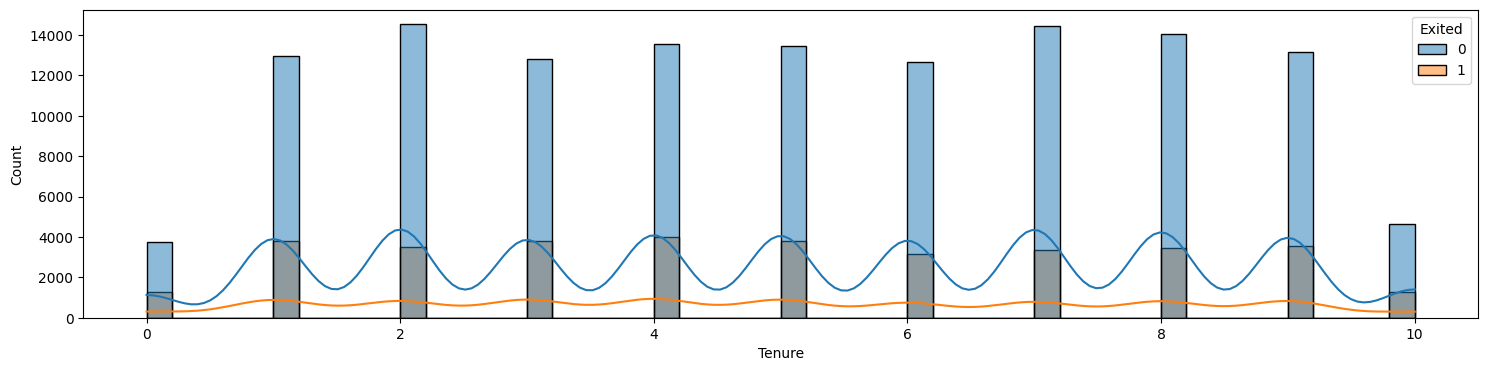

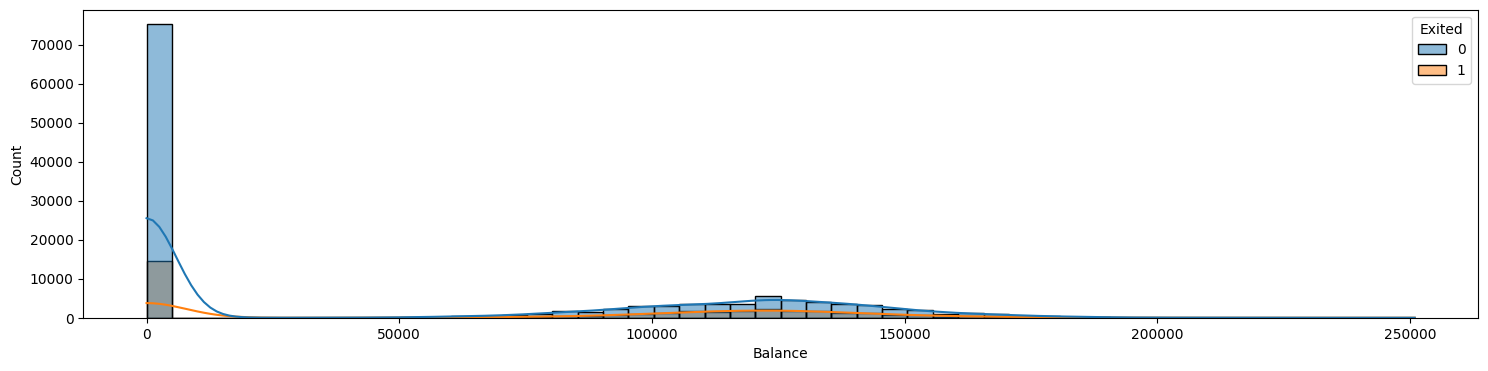

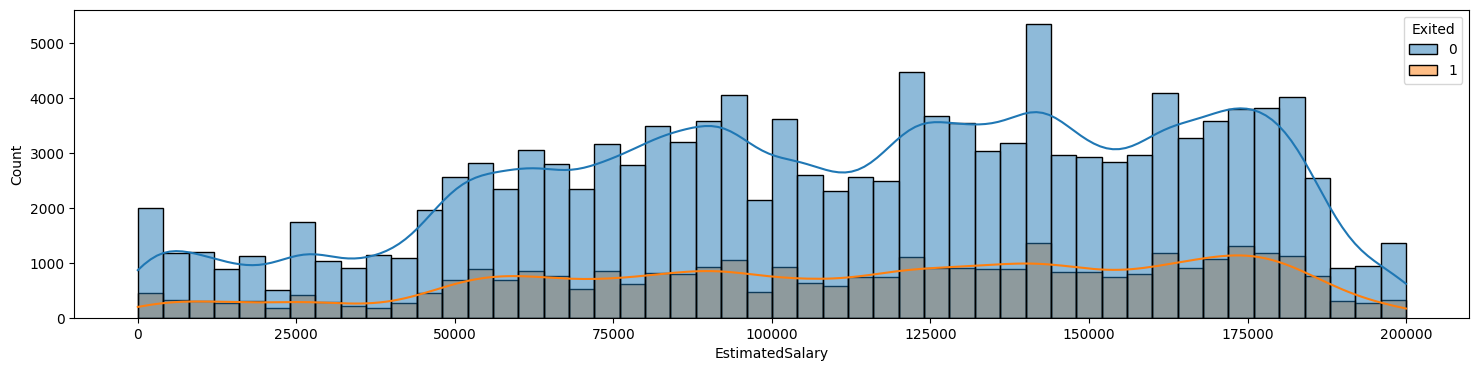

In [ ]:
# categorical_vars.remove('Geography')
for column in continuous_vars:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(data=data, x=column, hue="Exited", bins=50, kde=True)
    plt.show()

We observe that the balance variable predominantly contains 0 values, resulting in a skewed distribution toward 0. Other variables also exhibit skewness in their distributions. Additionally, the data distribution for both classes is nearly identical across all variables.
We now plot the correlation matrix heat map.

Now we perform the One hot encoding of categorical variable and standard scaling of continuous variables.


In [ ]:
dataset = data[categorical_vars+continuous_vars]
dataset = pd.get_dummies(dataset,columns = categorical_vars,drop_first = True)
dataset

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1.0,IsActiveMember_1.0
0,668,33.0,3,0.00,181449.97,False,False,True,True,False,False,True,False
1,627,33.0,1,0.00,49503.50,False,False,True,True,False,False,True,True
2,678,40.0,10,0.00,184866.69,False,False,True,True,False,False,True,False
3,581,34.0,2,148882.54,84560.88,False,False,True,False,False,False,True,True
4,716,33.0,5,0.00,15068.83,False,True,True,True,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,131834.75,False,True,False,False,False,False,True,True
165030,792,35.0,3,0.00,131834.45,False,False,True,False,False,False,False,False
165031,565,31.0,5,0.00,127429.56,False,False,True,False,False,False,True,True
165032,554,30.0,7,161533.00,71173.03,False,True,False,False,False,False,False,True


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for column in continuous_vars:
  dataset[column] = scaler.fit_transform(dataset[[column]])
dataset[continuous_vars]

,CreditScore,Age,Tenure,Balance,EstimatedSalary
0,0.636,0.202703,0.3,0.000000,0.907279
1,0.554,0.202703,0.1,0.000000,0.247483
2,0.656,0.297297,1.0,0.000000,0.924364
3,0.462,0.216216,0.2,0.593398,0.422787
4,0.732,0.202703,0.5,0.000000,0.075293
...,...,...,...,...,...
165029,0.634,0.202703,0.2,0.000000,0.659179
165030,0.884,0.229730,0.3,0.000000,0.659177
165031,0.430,0.175676,0.5,0.000000,0.637151
165032,0.408,0.162162,0.7,0.643819,0.355841


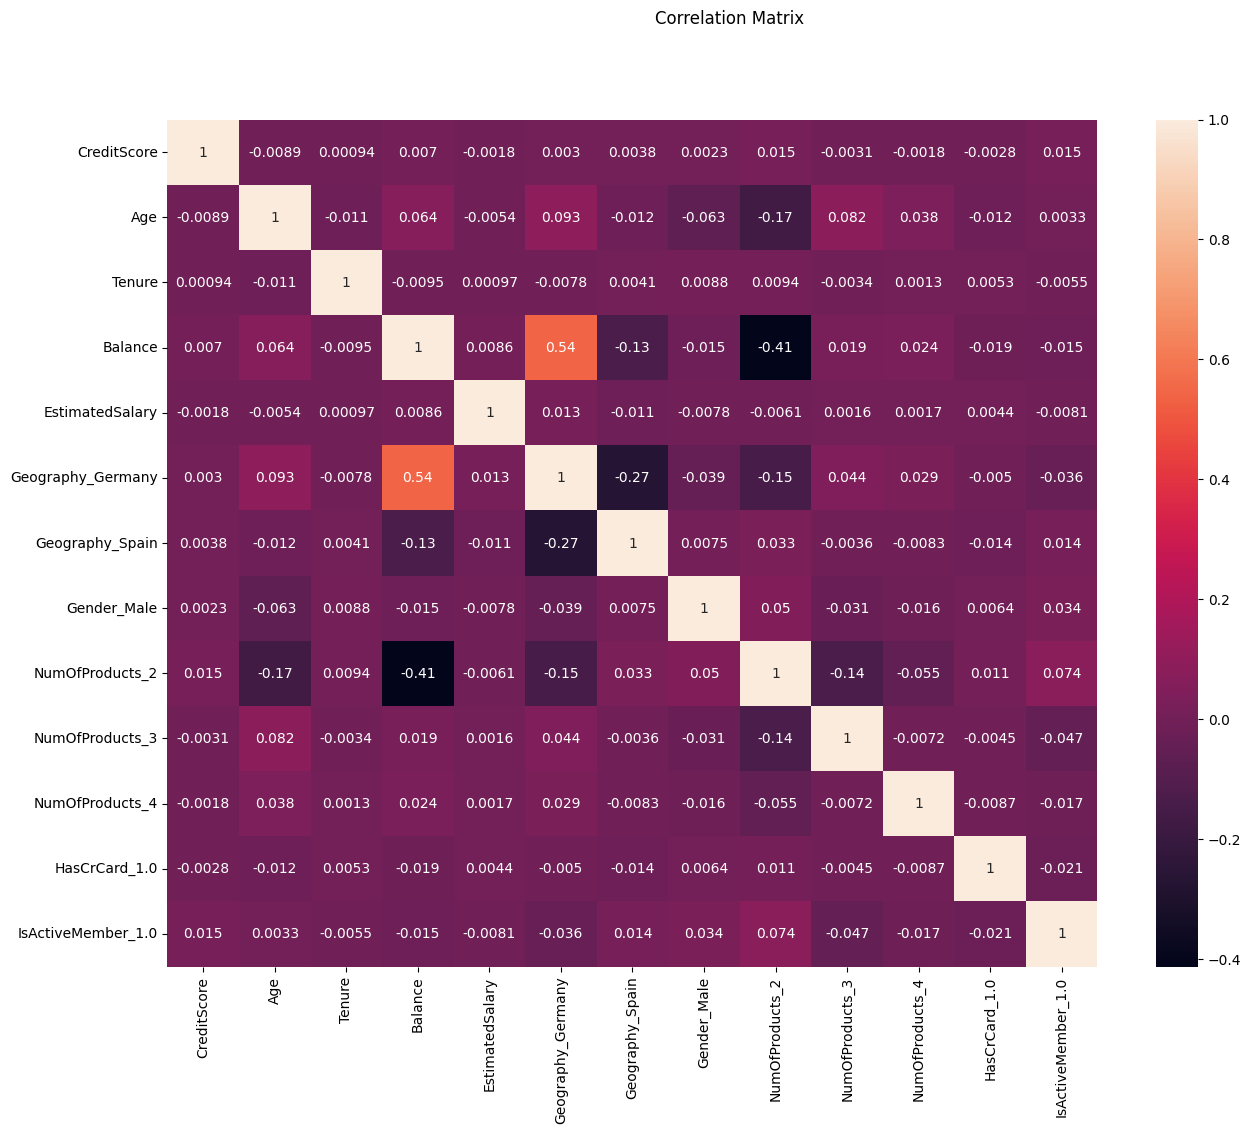

In [ ]:
t = categorical_vars + continuous_vars + ['Exited']
temp = dataset
corr_matrix = temp.corr()
f,ax=plt.subplots(figsize=(15,11))
sns.heatmap(corr_matrix,annot=True)
plt.suptitle('Correlation Matrix')
plt.show()

We now perform target variable analysis

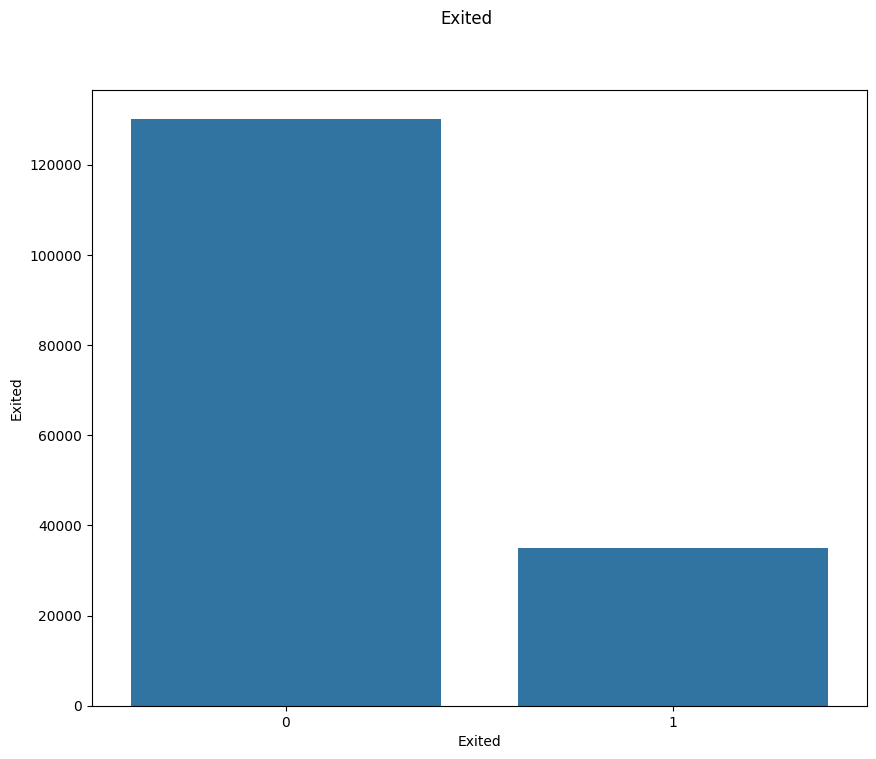



78.8% don't churn while 21.2% churn. The target variable is imbalanced.


In [ ]:
f,ax=plt.subplots(figsize=(10,8))
ax.set_ylabel('Exited')
sns.countplot(x='Exited',data=data,ax=ax)
plt.suptitle('Exited')
plt.show()
prop = data['Exited'].value_counts(normalize = True)
print("\n")
print(f"{round(prop[0],3)*100}% don't churn while {round(prop[1],3)*100}% churn. The target variable is imbalanced.")

We will handle class imbalance by splitting the test train data using stratified sampling and via applying SMOTE



In [ ]:
#stratified train test split
features = dataset
target = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    random_state=42,
                                                    stratify=target)
print(f"Proportion of churners in train data {y_train.sum()/len(y_train)} and in test data {y_test.sum()/len(y_test)}")

Proportion of churners in train data 0.21160169662694406 and in test data 0.211590198502145


#Training Various ML models with stratified train test split




We start with Logistic Regression. We will perform hyperparameter tuning using grid search.

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
import warnings
warnings.filterwarnings("ignore")
import joblib

logreg = LogisticRegression(solver='saga',random_state=42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],   # Regularization strength
    'penalty': ['l1', 'l2','elasticnet','none']
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_LR_model = grid_search.best_estimator_

model_path = '/content/drive/My Drive/Projects/Churn Prediction/best_LR_model.pkl'
joblib.dump(best_LR_model, model_path)

best_LR_model = joblib.load(model_path)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
y_prob = best_LR_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(roc_auc)

0.8538454381898439


In [ ]:
y_predictions = best_LR_model.predict(X_train)
print(classification_report(y_train, y_predictions))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     97584
           1       0.71      0.46      0.56     26191

    accuracy                           0.85    123775
   macro avg       0.79      0.70      0.73    123775
weighted avg       0.83      0.85      0.83    123775



In [ ]:
y_predictions = best_LR_model.predict(X_test)
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     32529
           1       0.72      0.46      0.56      8730

    accuracy                           0.85     41259
   macro avg       0.79      0.71      0.73     41259
weighted avg       0.84      0.85      0.83     41259



In [ ]:
best_LR_model

LogisticRegression(C=0.001, penalty='none', random_state=42, solver='saga')

We now train a Random forest model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


grid_search = GridSearchCV(RF_model, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)


grid_search.fit(X_train, y_train)

best_RF_model = grid_search.best_estimator_

model_path = '/content/drive/My Drive/Projects/Churn Prediction/best_RF_model.pkl'
joblib.dump(best_RF_model, model_path)

best_RF_model = joblib.load(model_path)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:

y_pred = best_RF_model.predict(X_test)


f1 = f1_score(y_test, y_pred)
print(f"F1 Score (Test Set): {f1:.4f}")


print("Classification Report:\n", classification_report(y_test, y_pred))

F1 Score (Test Set): 0.5872
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     32529
           1       0.72      0.49      0.59      8730

    accuracy                           0.85     41259
   macro avg       0.80      0.72      0.75     41259
weighted avg       0.84      0.85      0.84     41259



We now train Xgboost model for churn prediction

In [ ]:
from xgboost import XGBClassifier

XGB_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.01, 0.1],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}

grid_search = GridSearchCV(XGB_model, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_XGB_model = grid_search.best_estimator_

model_path = '/content/drive/My Drive/Projects/Churn Prediction/best_XGB_model.pkl'
joblib.dump(best_XGB_model, model_path)

best_XGB_model = joblib.load(model_path)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
y_pred = best_XGB_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score (Test Set): {f1:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

F1 Score (Test Set): 0.6326
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89     32529
           1       0.59      0.69      0.63      8730

    accuracy                           0.83     41259
   macro avg       0.75      0.78      0.76     41259
weighted avg       0.84      0.83      0.84     41259



#Training various ML algorithms with SMOTE applied on dataset

In [ ]:
features = dataset #dataset is already encoded
target = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    random_state=42)
print(f"Proportion of churners in train data {y_train.sum()/len(y_train)} before applying SMOTE")

Proportion of churners in train data 0.21248232680266613 before applying SMOTE


In [ ]:
from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=42)

X_train_smote, y_train_smote = oversampler.fit_resample(X_train, y_train)
print(f"Proportion of churners in train data {y_train_smote.sum()/len(y_train_smote)} after applying SMOTE")

Proportion of churners in train data 0.5 after applying SMOTE


We again train the ML models

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
import warnings
warnings.filterwarnings("ignore")
import joblib

logreg = LogisticRegression(solver='saga',random_state=42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],   # Regularization strength
    'penalty': ['l1', 'l2','elasticnet','none']
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

best_LR_model_smote = grid_search.best_estimator_

model_path = '/content/drive/My Drive/Projects/Churn Prediction/best_LR_model_smote.pkl'
joblib.dump(best_LR_model_smote, model_path)

best_LR_model_smote = joblib.load(model_path)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
y_predictions = best_LR_model_smote.predict(X_test)
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85     32638
           1       0.48      0.78      0.59      8621

    accuracy                           0.78     41259
   macro avg       0.70      0.78      0.72     41259
weighted avg       0.84      0.78      0.79     41259



In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RF_model, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

grid_search.fit(X_train_smote, y_train_smote)

best_RF_model_smote = grid_search.best_estimator_

model_path = '/content/drive/My Drive/Projects/Churn Prediction/best_RF_model_smote.pkl'
joblib.dump(best_RF_model_smote, model_path)

best_RF_model_smote = joblib.load(model_path)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
y_pred = best_RF_model_smote.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score (Test Set): {f1:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

F1 Score (Test Set): 0.5988
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89     32638
           1       0.58      0.62      0.60      8621

    accuracy                           0.83     41259
   macro avg       0.74      0.75      0.74     41259
weighted avg       0.83      0.83      0.83     41259



In [ ]:
from xgboost import XGBClassifier

XGB_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.01, 0.1],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}

grid_search = GridSearchCV(XGB_model, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

grid_search.fit(X_train_smote, y_train_smote)

best_XGB_model_smote = grid_search.best_estimator_

model_path = '/content/drive/My Drive/Projects/Churn Prediction/best_XGB_model_smote.pkl'
joblib.dump(best_XGB_model_smote, model_path)

best_XGB_model_smote = joblib.load(model_path)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
y_pred = best_XGB_model_smote.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score (Test Set): {f1:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

F1 Score (Test Set): 0.6279
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89     32638
           1       0.57      0.71      0.63      8621

    accuracy                           0.83     41259
   macro avg       0.74      0.78      0.76     41259
weighted avg       0.84      0.83      0.83     41259



In [ ]:
from xgboost import XGBClassifier

XGB_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.01, 0.1],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}

grid_search = GridSearchCV(XGB_model, param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)

grid_search.fit(X_train_smote, y_train_smote)

best_XGB_model_smote_auc = grid_search.best_estimator_

model_path = '/content/drive/My Drive/Projects/Churn Prediction/best_XGB_model_smote_auc.pkl'
joblib.dump(best_XGB_model_smote_auc, model_path)

best_XGB_model_smote = joblib.load(model_path)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
y_pred = best_XGB_model_smote_auc.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score (Test Set): {f1:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

F1 Score (Test Set): 0.6279
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89     32638
           1       0.57      0.71      0.63      8621

    accuracy                           0.83     41259
   macro avg       0.74      0.78      0.76     41259
weighted avg       0.84      0.83      0.83     41259



In [ ]:
y_prob = best_XGB_model_smote.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(roc_auc)

0.8742884025094761
